In [5]:
import torch
import os
import pickle
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
from bcnf.models.cnf import CondRealNVP
from bcnf.models.feature_network import FullyConnectedFeatureNetwork, LSTMFeatureNetwork, Transformer
from bcnf.train.train import train_CondRealNVP
from bcnf.utils import get_dir, ParameterIndexMapping
from bcnf.simulation.sampling import generate_data, generate_data_old
from bcnf.utils import partconv1d, get_gaussian_kernel

## Data

In [7]:
T = 2
dt = 1/15

In [8]:
dataset_name = "test_resimulation_data_T2_dt_1_15"

In [9]:
if not os.path.exists(os.path.join(get_dir('data', 'bcnf-data'), dataset_name + '.pkl')):
    data = generate_data(
        n=2000,
        output_type="trajectory",
        dt=dt,
        T=T,
        config_file=os.path.join(get_dir("configs"), "old.yaml"),
        verbose=True,
        break_on_impact=False,
        name=dataset_name,
        do_filter=False
    )
else:
    with open(os.path.join(get_dir('data', 'bcnf-data'), dataset_name + '.pkl'), 'rb') as f:
        data = pickle.load(f)

In [10]:
# data = generate_data_old(T=T, dt=dt, N=2000, break_on_impact=False)

In [11]:
all_parameters = list(data.keys())
print(all_parameters)

['x0_x', 'x0_y', 'x0_z', 'v0_x', 'v0_y', 'v0_z', 'g_x', 'g_y', 'g_z', 'w_x', 'w_y', 'w_z', 'b', 'm', 'a_x', 'a_y', 'a_z', 'cam_radian_array', 'r', 'A', 'Cd', 'rho', 'cam_radius', 'cam_angles', 'cam_heights', 'trajectory']


In [12]:
parameter_selection = ['x0_x','x0_y','x0_z','v0_x','v0_y','v0_z','g_x', 'g_y', "g_z",'w_x','w_y','w_z','b', 'm', 'a_x', 'a_y', 'a_z','r', 'A', 'Cd', 'rho']
for p in parameter_selection:
    if p not in all_parameters:
        print(f"Parameter {p} not found in data")

In [13]:
parameter_index_mapping = ParameterIndexMapping(parameter_selection)

In [14]:
X_list = data['trajectory']

In [15]:
X = np.array(X_list)
y = parameter_index_mapping.vectorize(data)

print(f'{X.shape=}')
print(f'{y.shape=}')

X.shape=(2000, 30, 3)
y.shape=(2000, 21)


In [12]:
STEPS = X.shape[1]
d = X.shape[2]

print(f'{STEPS=}')
print(f'{d=}')

STEPS=30
d=3


In [13]:
# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X.reshape(X.shape[0], -1), y, test_size=0.2, random_state=2024_03_25)

X_train = X_train.reshape(-1, STEPS, d)
X_val = X_val.reshape(-1, STEPS, d)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

print(f'{X_train_tensor.shape=}')
print(f'{y_train_tensor.shape=}')
print(f'{X_val_tensor.shape=}')
print(f'{y_val_tensor.shape=}')

X_train_tensor.shape=torch.Size([1600, 30, 3])
y_train_tensor.shape=torch.Size([1600, 21])
X_val_tensor.shape=torch.Size([400, 30, 3])
y_val_tensor.shape=torch.Size([400, 21])


## Model

In [14]:
config = {
    "data_kwargs": {
        "T": T,
        "dt": dt,
        "dataset_name": dataset_name,
        "parameter_selection": parameter_selection,
        "steps": STEPS,
    },
    "optimizer_kwargs": {
        "lr": 2e-4
    },
    "lr_scheduler_kwargs": {
        "mode": "min",
        "factor": 0.5,
        "patience": 250,
        "threshold_mode": "abs",
        "threshold": 1e-1,
    },
    "model_kwargs":{
        'size': y.shape[1],
        'condition_size': 80,
        'model_nested_size': 16,
        'model_nested_layers': 7,
        'model_n_blocks': 32,
        'model_act_norm': True,
        'model_dropout': 0.383,
        'feature_network': None,
        'time_series_network': 'LSTMFeatureNetwork',
        'time_series_network_input_size': d,
        'time_series_network_hidden_size': 16,
        'time_series_network_num_layers': 1,
        'time_series_network_dropout': 0.244,
        'time_series_network_bidirectional': True,
    }
}

In [15]:
time_series_network = LSTMFeatureNetwork(
    input_size=config['model_kwargs']['time_series_network_input_size'],
    hidden_size=config['model_kwargs']['time_series_network_hidden_size'],
    output_size=config['model_kwargs']['condition_size'],
    num_layers=config['model_kwargs']['time_series_network_num_layers'],
    dropout=config['model_kwargs']['time_series_network_dropout'],
    bidirectional=config['model_kwargs']['time_series_network_bidirectional']
).to(device)

# time_series_network = Transformer(
#     d_model=config['model_kwargs']['time_series_network_d_model'],
#     num_heads=config['model_kwargs']['time_series_network_num_heads'],
#     d_ff=config['model_kwargs']['time_series_network_d_ff'],
#     num_layers=config['model_kwargs']['time_series_network_num_layers'],
#     output_size=config['model_kwargs']['condition_size'],
#     dropout=0.1
# ).to(device)

/home/psaegert/miniconda3/envs/bcnf/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.244 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [16]:
cnf = CondRealNVP(
    size=config['model_kwargs']['size'],
    nested_sizes=[config['model_kwargs']['model_nested_size']] * config['model_kwargs']['model_nested_layers'],
    n_blocks=config['model_kwargs']['model_n_blocks'],
    dropout=config['model_kwargs']['model_dropout'],
    n_conditions=config['model_kwargs']['condition_size'],
    act_norm=config['model_kwargs']['model_act_norm'],
    feature_network=None,
    time_series_network=time_series_network,
    parameter_index_mapping=parameter_index_mapping).to(device)

optimizer = torch.optim.Adam(cnf.parameters(), lr=config['optimizer_kwargs']['lr'])

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode=config['lr_scheduler_kwargs']['mode'],
    factor=config['lr_scheduler_kwargs']['factor'],
    patience=config['lr_scheduler_kwargs']['patience'],
    threshold_mode=config['lr_scheduler_kwargs']['threshold_mode'],
    threshold=config['lr_scheduler_kwargs']['threshold'],
)

In [17]:
print(f'Number of parameters: {cnf.n_params:,}')

Number of parameters: 130,509


## Training

In [18]:
model_name = f'bcnf_traj_bilstm_{dataset_name}'

In [19]:
loss_history = {}

In [20]:
train_CondRealNVP(
    model=cnf,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_val=X_val_tensor,
    y_val=y_val_tensor,
    n_epochs=50_000,
    val_loss_patience=500,
    val_loss_tolerance=1e-1,
    val_loss_tolerance_mode="abs",
    batch_size=256,
    loss_history=loss_history
);

Train: -43.2478 - Val: -39.9743 (avg: -40.0185, min: -40.0032) | lr: 1.25e-05 - Patience: 92/500 - z: 0.0210 ± 0.9647:  16%|█▌        | 7759/50000 [42:52<3:53:22,  3.02it/s]  


KeyboardInterrupt: 

In [21]:
torch.save(cnf.state_dict(), os.path.join(get_dir('models', 'bcnf-models', model_name, create=True), f"state_dict.pt"))

with open(os.path.join(get_dir('models', 'bcnf-models', model_name, create=True), 'loss_history.pkl'), 'wb') as f:
    pickle.dump(loss_history, f)

with open(os.path.join(get_dir('models', 'bcnf-models', model_name, create=True), 'config.json'), 'w') as f:
    json.dump(config, f)

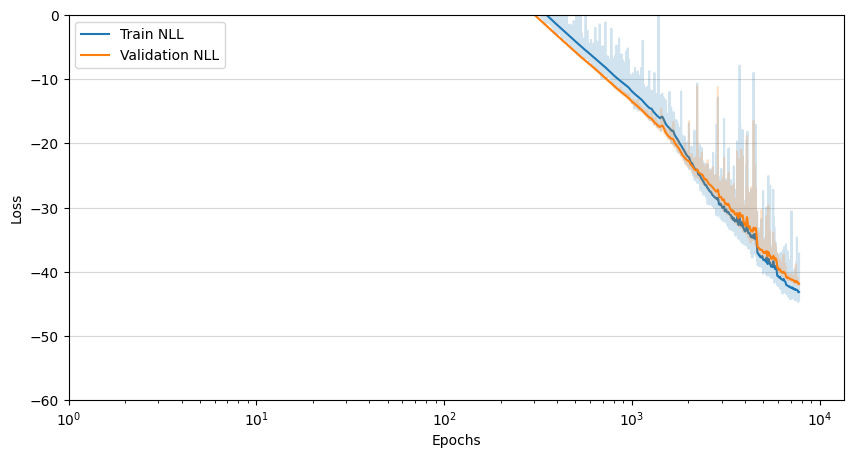

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

epochs = np.array([e for e, _ in loss_history['train']])
losses = np.array([l for _, l in loss_history['train']])

ax.plot(epochs, losses, alpha=0.2, color='C0')
ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=100)), label='Train NLL', color='C0')

epochs = np.array([e for e, _ in loss_history['val']])
losses = np.array([l for _, l in loss_history['val']])

ax.plot(epochs, losses, alpha=0.2, color='C1')
ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=20)), label='Validation NLL', color='C1')

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

ax.set_xscale('log')
ax.set_ylim(-60, 0)
ax.set_xlim(1, None)
ax.grid(axis='y', alpha=0.5)

ax.legend();